## Topic Modeling
# PCA Feature Components
### Prabhjot Singh

This notebook goes through how topic modeling was performed. Code was largely based off of material from DS 5001. 

In [2]:
# load packages
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [22]:
# defining the OHCO
# setting OHCO
OHCO = ["EVENT_Label","EVENT_ID", "para_num", "sent_num", "token_num"] # event ID is the chapter number 

# setting the bags
SENTS = OHCO[:4]
PARAS = OHCO[:3]
EVENT_ID = OHCO[:2]
EVENT_TYPE = OHCO[:1]

BAG = EVENT_ID

In [7]:
# read in the TOKEN, VOCAB, and LIB files
# LIB = pd.read_csv("LIB2020.csv")
# LIB_Types = pd.read_csv("all_lib_types.csv", index_col=[0])
TOKEN = pd.read_csv("all_TOKEN.csv") # only token is needed right now
# VOCAB = pd.read_csv("all_VOCAB.csv").set_index("term_str")

In [9]:
TOKEN["pos"].unique()

array(['VBN', 'IN', 'NNP', 'CD', 'NNS', 'NN', 'VBD', 'DT', 'CC', 'RB',
       'JJ', 'RP', 'TO', 'PRP$', 'VBP', 'VBG', '$', 'JJS', 'VB', 'VBZ',
       'WDT', 'WP', 'JJR', 'WRB', 'PRP', 'EX', 'NNPS', 'MD', 'RBS', 'FW',
       ':', 'RBR', 'PDT', 'POS', '.', 'WP$', ',', '(', '#', "''", ')',
       'SYM', 'UH', 'LS', '``'], dtype=object)

In [14]:
TOKEN["term_str"] = TOKEN["term_str"].astype("str")

In [18]:
# getting the DOC table --- grouping by bag of event id, which is a specific instance of a particular storm 
DOCS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [20]:
# checking DOC table
DOCS

doc_str
EVENT_Label EVENT_ID                                                   
1           10377                                            gust knots
            10380                                            gust knots
            11256                                        knot wind gust
            11261                                        knot wind gust
            11283                                        knot wind gust
...                                                                 ...
56          5389377                layer ash volcano spread mid norning
            5627050                           pilot cloud altitude feet
            5627051                               pilots ash cloud feet
            5689788   volcano monday eruption hours winds levels ash...
            5689791                       eruption pm plume communities

[786741 rows x 1 columns]

In [21]:
# used 4000 terms, 40 topics
ngram_range = [1,2]
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 10

#### Creating Vector Space

In [22]:
# create the vector space
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names()

#### Generating the LDA Model

In [23]:
# generate the model
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

#### Computing THETA

In [24]:
# THETA
THETA = pd.DataFrame(lda_engine.fit_transform(count_model), index=DOCS.index)
THETA.columns.name = 'topic_id'

In [25]:
THETA.sample(20).style.background_gradient()

#### Computing PHI

In [26]:
# PHI
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [27]:
PHI.T.sample(10).style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
floor,0.025000,0.025000,0.025000,0.025000,37.514057,0.025000,0.025000,0.025000,0.025000,7.589822,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,578.689136,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,160.235148,0.025000,0.025000,0.025000,190.096837,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
respectively,0.025000,0.025000,53.024467,0.025000,29.372428,0.025000,0.025000,0.025000,93.654427,0.025000,39.780266,0.025000,106.571507,0.025000,29.962954,0.025000,0.025000,157.475496,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,9.169242,0.025000,0.025000,0.025000,19.214212
excess,0.025000,0.025000,0.025000,0.025000,0.025000,522.246056,0.025000,0.025000,0.025000,0.025000,1105.701473,0.025000,0.025000,0.025000,118.850029,38.992846,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.427477,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.336997,936.587318,0.025000,1276.057804
county area,0.025000,0.025000,0.025000,0.025000,93.146983,0.025000,0.025000,65.133668,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,372.177089,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.642261,0.025000,0.025000,0.025000,0.025000
transmission,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,107.380600,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,356.951368,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,21.743032,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
damage estimate,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1137.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
time water,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,6.963967,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,203.086033,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
flooding water,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1680.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
river river,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,399.025000,0.025000,0.025000,0.025000,0.025000


#### Computing TOPIC Entropy over Terms

In [30]:
PHI_P = (PHI.T / PHI.T.sum())
PHI_I = np.log(1/PHI_P)
TOPIC_H = round((PHI_I * PHI_P).sum().sort_values(ascending=False), 2)

<AxesSubplot:ylabel='Density'>

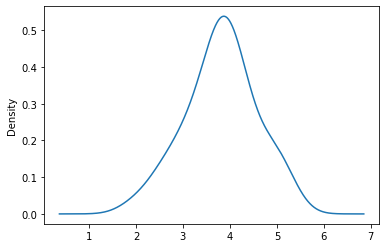

In [31]:
# visualizing the entropy over the terms
TOPIC_H.plot.kde()

#### Computing DOC Entropy over Topics

In [32]:
THETA_I = np.log(1/THETA.T)
DOC_H = (THETA_I * THETA.T).sum()

<AxesSubplot:ylabel='Density'>

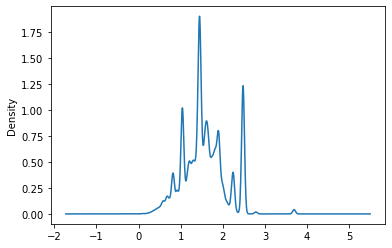

In [33]:
# visualiziing the DOC entropy over topics
DOC_H.plot.kde()

#### Creating TOPICS and Top Terms Per Topic

In [34]:
# topic creation 
TOPICS = PHI.stack().to_frame().rename(columns={0:'topic_weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
        x.sort_values('topic_weight', ascending=False)\
               .head(n_top_terms)\
               .reset_index()\
               .drop('topic_id',1)['term_str'])

In [35]:
TOPICS[[t for t in range(n_top_terms)]]

term_str,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,hail,size,size hail,quarter,quarter size,quarter hail,ground,reported,hail reported,radio
1,knots,site,ft,region,gusts knots,gusts,spotters,slideoffs,elevation,site elevation
2,inches,inches inches,snowfall,amounts,county,total,totals,amounts inches,inches county,totals inches
3,tree,radar,time,car,tree power,winds,limb,block,home,tree home
4,flooding,roads,rain,county,waters,area,flash,flood,streets,flash flooding
5,gust,wind,wind gust,mph,gust mph,knots,station,gust knots,mph wind,thunderstorm
6,rainfall,inches,rainfall inches,damage,storm,inches rainfall,estimates,values,damage values,section
7,rain,inches,inches rain,county,portions,roads,accidents,vehicle,traffic,portions county
8,inches,snow,inches snow,observer,snow inches,spotter,spotter inches,observer inches,feet,county


#### Most Frequently Appearing Terms

In [114]:
# TOPICS.stack().to_frame('term').value_counts().to_frame('n').head(5)#.sort_values('n')#.plot.barh(figsize=(5,15))

In [37]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ', '.join(x[:n_top_terms]), 1)

#### TOPICS by DOC Weight

In [38]:
TOPICS['doc_weight_sum'] = THETA.sum()

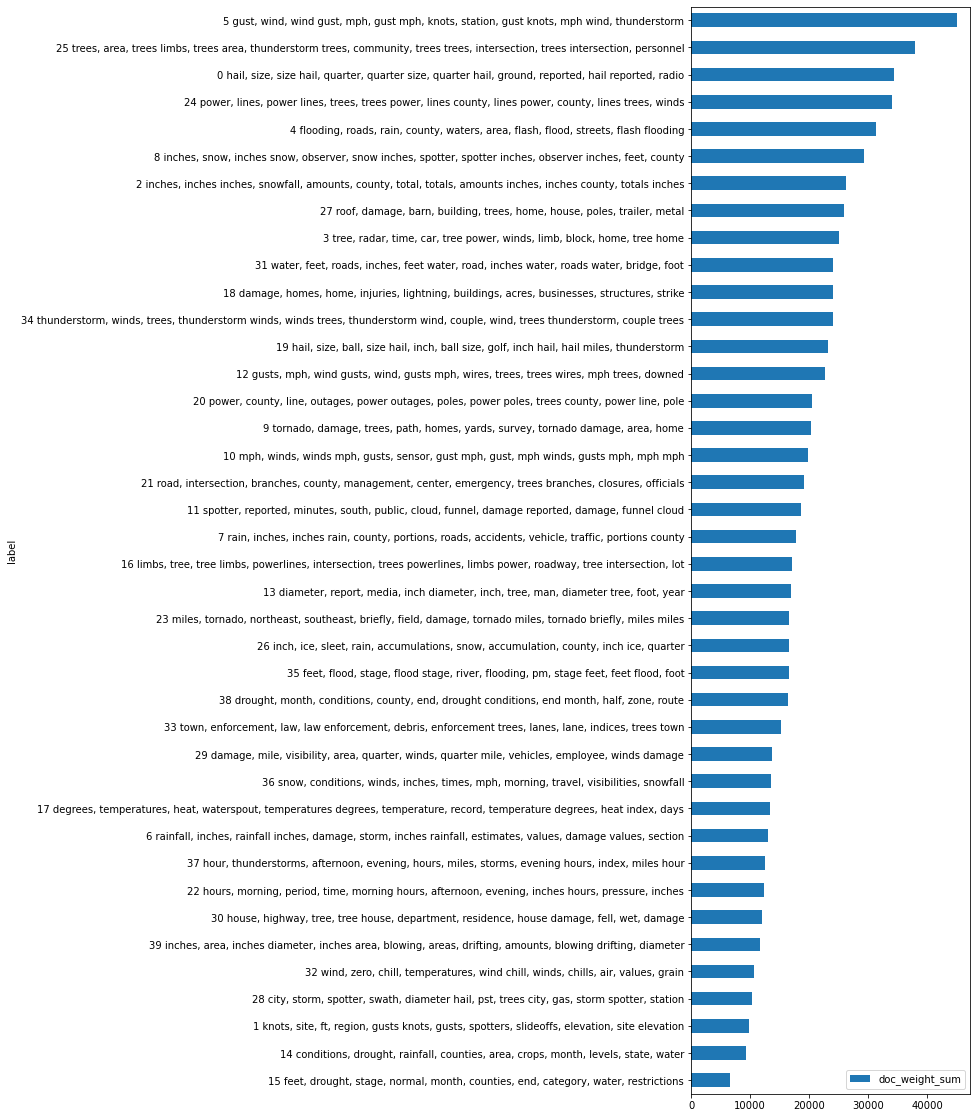

In [39]:
# visualizing the obtained topics
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,n_topics/2));

In [117]:
## saving the files if needed to come back to
# TOPICS.to_csv("LDA_TOPICS.csv")
# THETA.to_csv('LDA_THETA.csv')
# PHI.to_csv('LDA_PHI.csv')

#### Exploring Topics by Strom Type

In [115]:
# ngram_range = [1,2]
# n_terms = 4000
# n_topics = 40
# max_iter = 20
# n_top_terms = 10

In [27]:
# reopening files 
TOPICS = pd.read_csv("LDA_TOPICS.csv")
THETA = pd.read_csv('LDA_THETA.csv')
PHI = pd.read_csv('LDA_PHI.csv')

#### Setting up Labels for PCA
EVENT_Type was added so Topic could be assigned to a type of weather that most closely resembles the distirbution. 

In [14]:
LIB_Types = pd.read_csv("all_lib_types.csv", index_col=[0])

In [20]:
event_types = LIB_Types.set_index('EVENT_Label')['EVENT_TYPE'].to_dict()

In [28]:
THETA["EVENT_TYPE"] = THETA.EVENT_Label.map(event_types)

In [29]:
THETA

,EVENT_Label,EVENT_ID,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,EVENT_TYPE
0,1,10377,0.006250,0.006250,0.006250,0.006250,0.006250,0.756250,0.006250,0.006250,...,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,Marine Thunderstorm Wind
1,1,10380,0.006250,0.006250,0.006250,0.006250,0.006250,0.756250,0.006250,0.006250,...,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,Marine Thunderstorm Wind
2,1,11256,0.004167,0.004167,0.004167,0.004167,0.004167,0.837500,0.004167,0.004167,...,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,Marine Thunderstorm Wind
3,1,11261,0.004167,0.004167,0.004167,0.004167,0.004167,0.837500,0.004167,0.004167,...,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,Marine Thunderstorm Wind
4,1,11283,0.004167,0.004167,0.004167,0.004167,0.004167,0.837500,0.004167,0.004167,...,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,Marine Thunderstorm Wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786736,56,5389377,0.006250,0.292354,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,...,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,Volcanic Ash
786737,56,5627050,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,...,0.006250,0.006250,0.006250,0.006250,0.256250,0.006250,0.006250,0.006250,0.006250,Volcanic Ash
786738,56,5627051,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.341667,0.008333,0.008333,0.008333,0.008333,Volcanic Ash
786739,56,5689788,0.001786,0.001786,0.001786,0.001786,0.142277,0.001786,0.001786,0.001786,...,0.001786,0.001786,0.143941,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,Volcanic Ash


In [50]:
topic_cols = [str(t) for t in range(n_topics)] # had to set as str, otherwise doesn't recognize

In [31]:
STORM_TYPES = THETA.reset_index().set_index(['EVENT_TYPE']+BAG)

In [52]:
STORM_TYPES = STORM_TYPES.groupby('EVENT_TYPE')[topic_cols].mean()

In [120]:
# STORM_TYPES

In [54]:
STORM_TYPES = STORM_TYPES.T                                        
STORM_TYPES.index.name = 'topic_id'

In [94]:
top_lab = TOPICS[["topic_id", "label"]].set_index("topic_id")["label"].to_dict()

In [121]:
# STORM_TYPES['label'] = STORM_TYPES.topic_id.map(top_lab)

In [91]:
STORM_TYPES

EVENT_TYPE,Astronomical Low Tide,Avalanche,Blizzard,Coastal Flood,Cold/Wind Chill,Debris Flow,Dense Fog,Dense Smoke,Drought,Dust Devil,...,Tropical Depression,Tropical Storm,Tsunami,Volcanic Ash,Volcanic Ashfall,Waterspout,Wildfire,Winter Storm,Winter Weather,label
topic_id,,,,,,,,,,,,,,,,,,,,,
0,0.007162,0.005548,0.002346,0.003885,0.004215,0.007214,0.004008,0.004556,0.003987,0.003711,...,0.001828,0.003787,0.003679,0.006324,0.006288,0.007311,0.007843,0.003285,0.004418,NaN
1,0.027580,0.007269,0.005450,0.027207,0.006707,0.009690,0.009383,0.007801,0.005587,0.003651,...,0.025409,0.015560,0.009740,0.042087,0.006288,0.019740,0.006153,0.018779,0.020401,NaN
2,0.013932,0.017136,0.079799,0.004128,0.004151,0.007575,0.004112,0.004556,0.016923,0.004009,...,0.029250,0.021111,0.003679,0.006324,0.006288,0.007217,0.006346,0.213531,0.160222,NaN
3,0.110382,0.008239,0.003594,0.044291,0.004354,0.011940,0.004835,0.004556,0.003877,0.007431,...,0.034707,0.034291,0.036744,0.006324,0.063950,0.013303,0.009135,0.003473,0.004259,NaN
4,0.009459,0.008495,0.004073,0.120802,0.004099,0.041157,0.004257,0.006829,0.004113,0.002754,...,0.010585,0.029438,0.003679,0.023886,0.006288,0.011483,0.009106,0.004797,0.005557,NaN
5,0.007250,0.009965,0.023179,0.004422,0.010886,0.006346,0.006346,0.019707,0.003675,0.022466,...,0.136977,0.095370,0.008124,0.024182,0.006288,0.012278,0.006999,0.006874,0.004377,NaN
6,0.042523,0.007948,0.003706,0.048375,0.006645,0.029025,0.004878,0.004556,0.029685,0.008934,...,0.153388,0.133457,0.079882,0.006324,0.006288,0.011990,0.010921,0.004138,0.004317,NaN
7,0.005327,0.011691,0.014320,0.014283,0.004755,0.034590,0.025553,0.076147,0.023102,0.006419,...,0.029307,0.022946,0.003679,0.041962,0.006288,0.009865,0.011043,0.028944,0.069286,NaN
8,0.035823,0.065186,0.048378,0.003909,0.005094,0.006928,0.004098,0.004556,0.005465,0.003124,...,0.001828,0.003397,0.003679,0.006324,0.006288,0.009638,0.005171,0.227202,0.210163,NaN


In [66]:
types = LIB_Types["EVENT_TYPE"].to_list()

In [100]:
STORM_TYPES.columns

Index(['Astronomical Low Tide', 'Avalanche', 'Blizzard', 'Coastal Flood',
       'Cold/Wind Chill', 'Debris Flow', 'Dense Fog', 'Dense Smoke', 'Drought',
       'Dust Devil', 'Dust Storm', 'Excessive Heat', 'Extreme Cold/Wind Chill',
       'Flash Flood', 'Flood', 'Freezing Fog', 'Frost/Freeze', 'Funnel Cloud',
       'Hail', 'Heat', 'Heavy Rain', 'Heavy Snow', 'High Surf', 'High Wind',
       'Hurricane', 'Hurricane (Typhoon)', 'Ice Storm', 'Lake-Effect Snow',
       'Lakeshore Flood', 'Landslide', 'Lightning', 'Marine Dense Fog',
       'Marine Hail', 'Marine High Wind', 'Marine Hurricane/Typhoon',
       'Marine Strong Wind', 'Marine Thunderstorm Wind',
       'Marine Tropical Depression', 'Marine Tropical Storm', 'Rip Current',
       'Seiche', 'Sleet', 'Sneakerwave', 'Storm Surge/Tide', 'Strong Wind',
       'Thunderstorm Wind', 'Tornado', 'Tropical Depression', 'Tropical Storm',
       'Tsunami', 'Volcanic Ash', 'Volcanic Ashfall', 'Waterspout', 'Wildfire',
       'Winter Storm',

In [101]:
STORM_TYPES["EVENT_TYPE"] = STORM_TYPES[['Astronomical Low Tide', 'Avalanche', 'Blizzard', 'Coastal Flood',
       'Cold/Wind Chill', 'Debris Flow', 'Dense Fog', 'Dense Smoke', 'Drought',
       'Dust Devil', 'Dust Storm', 'Excessive Heat', 'Extreme Cold/Wind Chill',
       'Flash Flood', 'Flood', 'Freezing Fog', 'Frost/Freeze', 'Funnel Cloud',
       'Hail', 'Heat', 'Heavy Rain', 'Heavy Snow', 'High Surf', 'High Wind',
       'Hurricane', 'Hurricane (Typhoon)', 'Ice Storm', 'Lake-Effect Snow',
       'Lakeshore Flood', 'Landslide', 'Lightning', 'Marine Dense Fog',
       'Marine Hail', 'Marine High Wind', 'Marine Hurricane/Typhoon',
       'Marine Strong Wind', 'Marine Thunderstorm Wind',
       'Marine Tropical Depression', 'Marine Tropical Storm', 'Rip Current',
       'Seiche', 'Sleet', 'Sneakerwave', 'Storm Surge/Tide', 'Strong Wind',
       'Thunderstorm Wind', 'Tornado', 'Tropical Depression', 'Tropical Storm',
       'Tsunami', 'Volcanic Ash', 'Volcanic Ashfall', 'Waterspout', 'Wildfire',
       'Winter Storm', 'Winter Weather']].idxmax(1)

In [104]:
# checking df
STORM_TYPES

EVENT_TYPE,Astronomical Low Tide,Avalanche,Blizzard,Coastal Flood,Cold/Wind Chill,Debris Flow,Dense Fog,Dense Smoke,Drought,Dust Devil,...,Tropical Storm,Tsunami,Volcanic Ash,Volcanic Ashfall,Waterspout,Wildfire,Winter Storm,Winter Weather,label,EVENT_TYPE
topic_id,,,,,,,,,,,,,,,,,,,,,
0,0.007162,0.005548,0.002346,0.003885,0.004215,0.007214,0.004008,0.004556,0.003987,0.003711,...,0.003787,0.003679,0.006324,0.006288,0.007311,0.007843,0.003285,0.004418,NaN,Hail
1,0.027580,0.007269,0.005450,0.027207,0.006707,0.009690,0.009383,0.007801,0.005587,0.003651,...,0.015560,0.009740,0.042087,0.006288,0.019740,0.006153,0.018779,0.020401,NaN,Marine Tropical Depression
2,0.013932,0.017136,0.079799,0.004128,0.004151,0.007575,0.004112,0.004556,0.016923,0.004009,...,0.021111,0.003679,0.006324,0.006288,0.007217,0.006346,0.213531,0.160222,NaN,Heavy Snow
3,0.110382,0.008239,0.003594,0.044291,0.004354,0.011940,0.004835,0.004556,0.003877,0.007431,...,0.034291,0.036744,0.006324,0.063950,0.013303,0.009135,0.003473,0.004259,NaN,Astronomical Low Tide
4,0.009459,0.008495,0.004073,0.120802,0.004099,0.041157,0.004257,0.006829,0.004113,0.002754,...,0.029438,0.003679,0.023886,0.006288,0.011483,0.009106,0.004797,0.005557,NaN,Flash Flood
5,0.007250,0.009965,0.023179,0.004422,0.010886,0.006346,0.006346,0.019707,0.003675,0.022466,...,0.095370,0.008124,0.024182,0.006288,0.012278,0.006999,0.006874,0.004377,NaN,Marine Thunderstorm Wind
6,0.042523,0.007948,0.003706,0.048375,0.006645,0.029025,0.004878,0.004556,0.029685,0.008934,...,0.133457,0.079882,0.006324,0.006288,0.011990,0.010921,0.004138,0.004317,NaN,Hurricane
7,0.005327,0.011691,0.014320,0.014283,0.004755,0.034590,0.025553,0.076147,0.023102,0.006419,...,0.022946,0.003679,0.041962,0.006288,0.009865,0.011043,0.028944,0.069286,NaN,Heavy Rain
8,0.035823,0.065186,0.048378,0.003909,0.005094,0.006928,0.004098,0.004556,0.005465,0.003124,...,0.003397,0.003679,0.006324,0.006288,0.009638,0.005171,0.227202,0.210163,NaN,Heavy Snow


In [110]:
# importing additional files needed.
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [111]:
def plot_tree(tree, labels, color_thresh=1):
    plt.figure()
    fig_height = n_topics / 2
    fig, axes = plt.subplots(figsize=(5, fig_height))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left", color_threshold=color_thresh)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig('topic_clusters.png')

In [112]:
SIMS = pdist(normalize(PHI), metric='cosine')
TREE = sch.linkage(SIMS, method='ward')

In [108]:
# labels = LIB_Types[["EVENT_TYPE"]]
# labels = labels.EVENT_TYPE.values

labels  = ["{} {}".format(a,b) 
           for a, b in zip(STORM_TYPES.EVENT_TYPE, TOPICS.label.tolist())]

In [109]:
labels

['Hail 0 hail, size, size hail, quarter, quarter size, quarter hail, ground, reported, hail reported, radio',
 'Marine Tropical Depression 1 knots, site, ft, region, gusts knots, gusts, spotters, slideoffs, elevation, site elevation',
 'Heavy Snow 2 inches, inches inches, snowfall, amounts, county, total, totals, amounts inches, inches county, totals inches',
 'Astronomical Low Tide 3 tree, radar, time, car, tree power, winds, limb, block, home, tree home',
 'Flash Flood 4 flooding, roads, rain, county, waters, area, flash, flood, streets, flash flooding',
 'Marine Thunderstorm Wind 5 gust, wind, wind gust, mph, gust mph, knots, station, gust knots, mph wind, thunderstorm',
 'Hurricane 6 rainfall, inches, rainfall inches, damage, storm, inches rainfall, estimates, values, damage values, section',
 'Heavy Rain 7 rain, inches, inches rain, county, portions, roads, accidents, vehicle, traffic, portions county',
 'Heavy Snow 8 inches, snow, inches snow, observer, snow inches, spotter, spot

<Figure size 432x288 with 0 Axes>

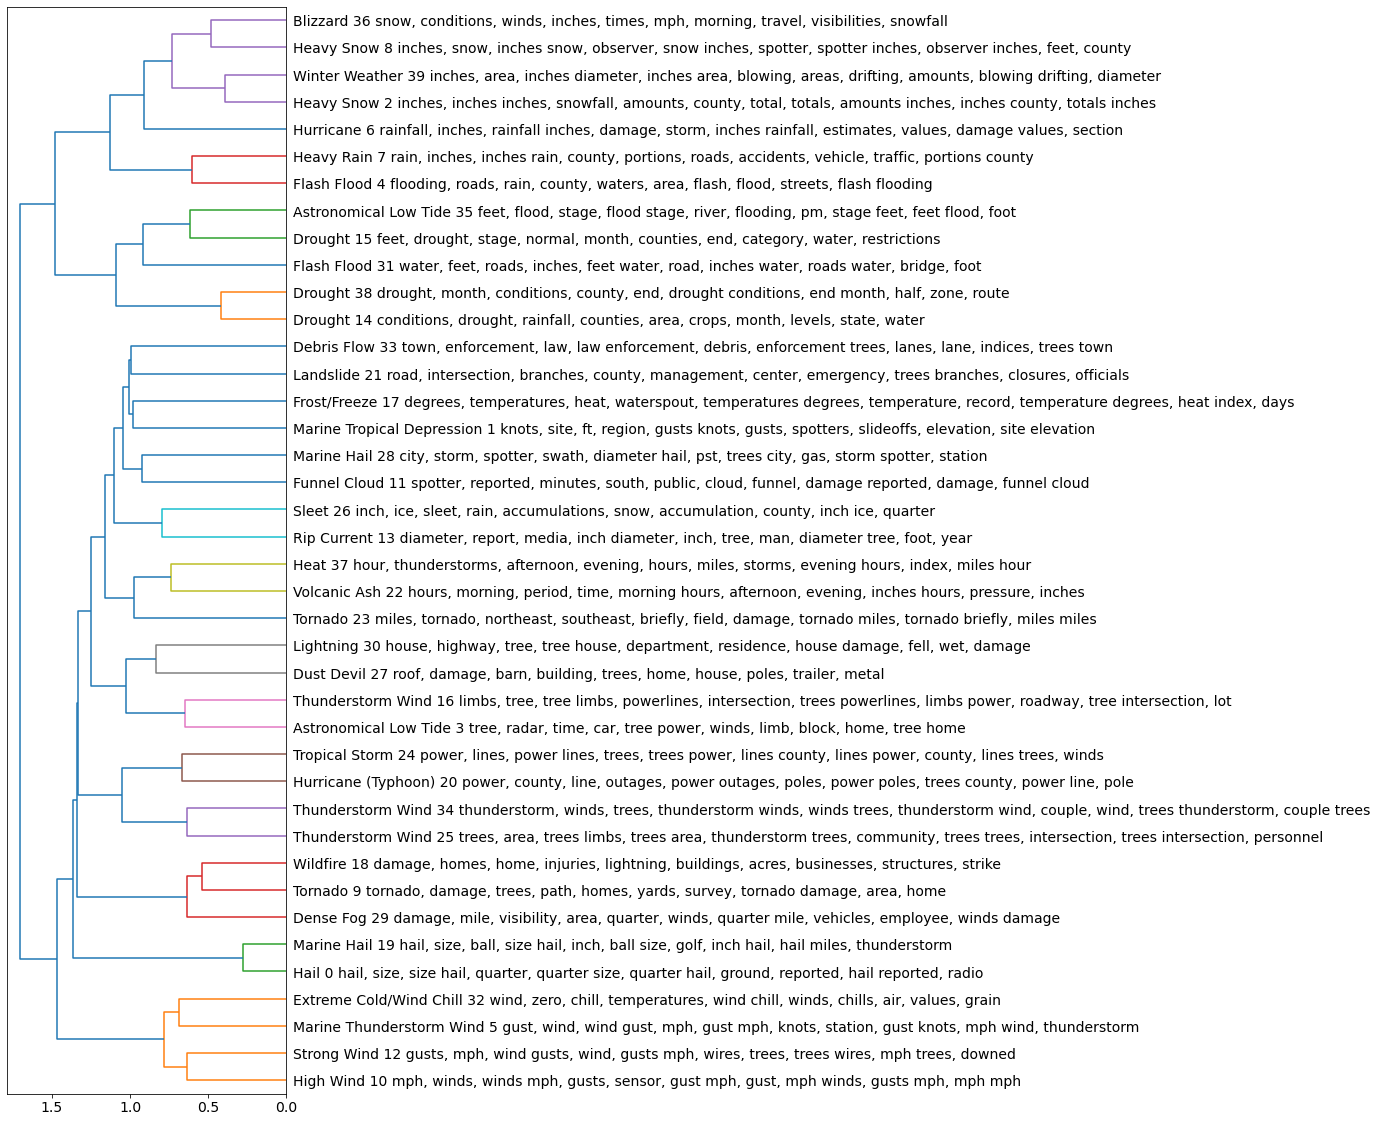

In [113]:
plot_tree(TREE,labels, .9)

In [61]:
plt.savefig('topic_clusters.png')

<Figure size 432x288 with 0 Axes>